### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

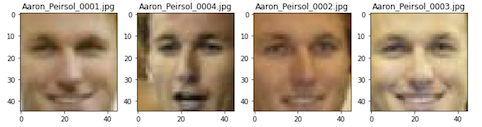

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

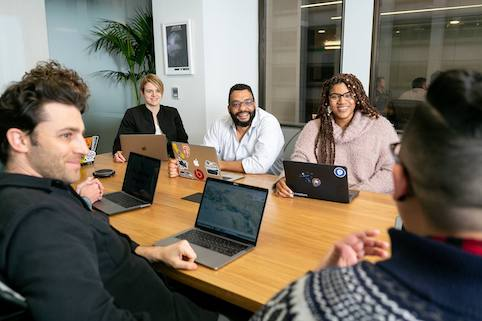

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

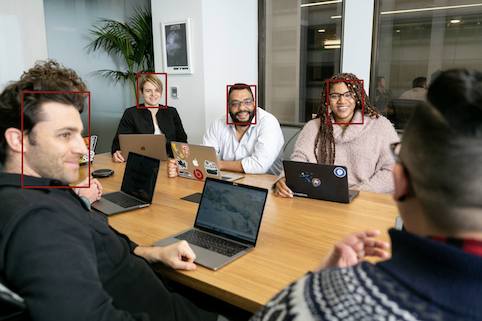

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

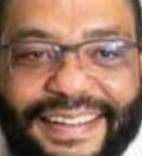

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

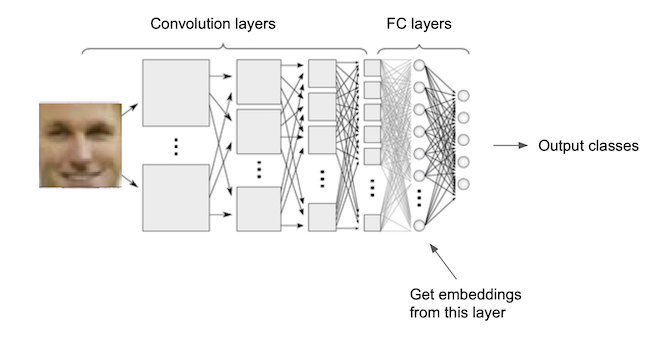

# Tasks

## Task 1 (30% points): build a neural network for faces classification as discribed above.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import pandas as pd
from IPython.display import clear_output

import random
import torch.nn.functional as F
from tqdm import tqdm, trange

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [ ]:
! wget "https://s585sas.storage.yandex.net/rdisk/cf049166fe29f8aaa6b2d9c0b449bbbd8f70aaedc2f876c1347ce80adbc56e13/6206a22e/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg==?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2&rtoken=xPP8vvNmAlQ7&force_default=no&ycrid=na-038f8edbf493d3316e85ac7e2f7a912c-downloader13h&ts=5d7c1b82a6780&s=c40a2f16e4c74963aa61a49a29f8b0a5e667c2186b059ee6c5dfa5e0a8ec6724&pb=U2FsdGVkX19UY-FznABtgto_87xlxvDEriMH-2tk6GhjFjp4Rneb8N6HT81d45zvy6sSWfxHrl_CtXbjG_vv_l31ckRQJ150Qubnk28v0VA" -O celebA.zip
! unzip celebA.zip

Let's look at the data first:

In [ ]:
! ls celebA_train_500

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import random
import pandas as pd
import seaborn as sns

In [ ]:
full_names = os.listdir('./celebA_train_500/celebA_imgs/')
len(full_names)

23948

In [ ]:
f = open('celebA_train_500/celebA_anno.txt', 'r')
lines = f.readlines()
person = [x.strip().split() for x in lines]
person_img = dict()
for i in person:
    if i[1] not in person_img:
       person_img[i[1]] = []
    person_img[i[1]].append(i[0])

df = pd.DataFrame(data=person_img.items(), columns=['person', 'imgs'])
df['count_img'] = df['imgs'].str.len()
df = df.drop('person', axis=1)
df

imgs  count_img
0    [000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...         30
1    [000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...         30
2    [000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...         30
3    [000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...         30
4    [000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...         25
..                                                 ...        ...
495  [000515.jpg, 005410.jpg, 020137.jpg, 024989.jp...         20
496  [000516.jpg, 033078.jpg, 058354.jpg, 059067.jp...         22
497  [000517.jpg, 001649.jpg, 029332.jpg, 034151.jp...         22
498  [000518.jpg, 001543.jpg, 003209.jpg, 008966.jp...         30
499  [000519.jpg, 004754.jpg, 005061.jpg, 007359.jp...         28

[500 rows x 2 columns]

In [ ]:
# Count labeled data

df['count_img'].sum()

12011

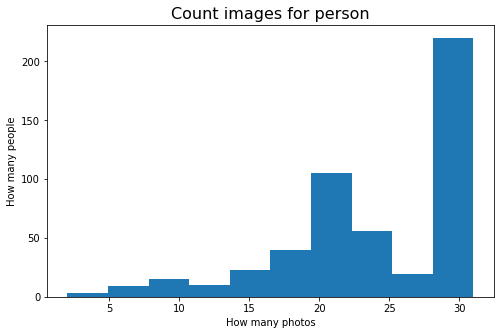

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df['count_img'])
plt.title('Count images for person', fontsize=16)
plt.ylabel('How many people')
plt.xlabel('How many photos')
plt.show()

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(4*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].grid(False)
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

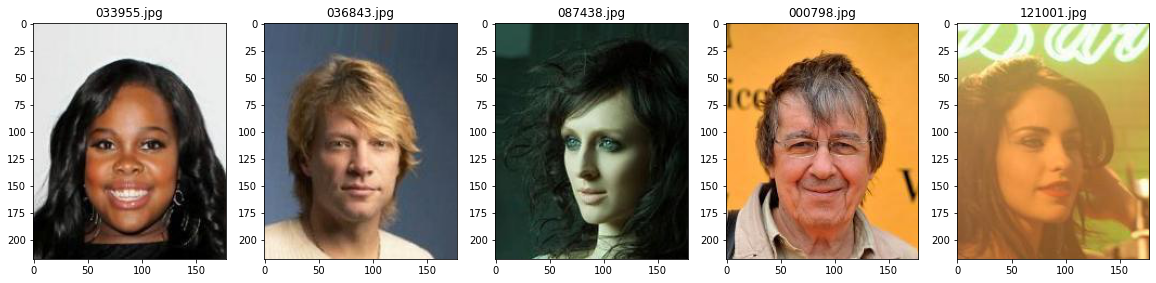

In [ ]:
# five random person

random_numbers = random.sample(range(0, len(full_names)), 5)
images_names = [full_names[x] for x in random_numbers]
show_imgs(images_names)

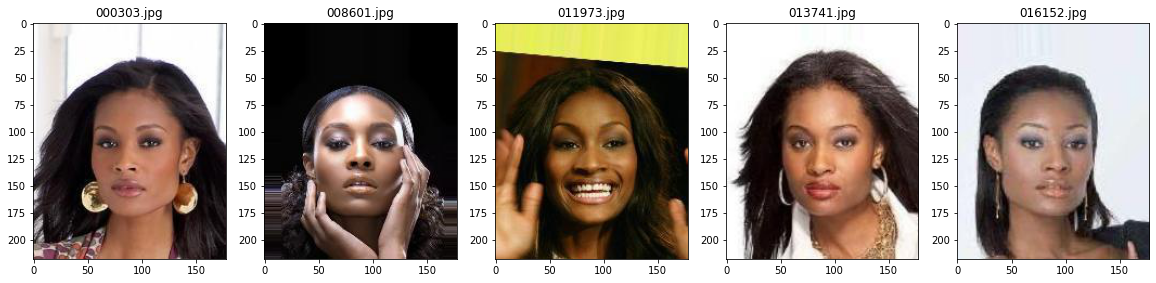

In [ ]:
# one random person, 5 images

lst = df.iloc[random.randint(0,len(df))]['imgs'][:5]
show_imgs(lst)

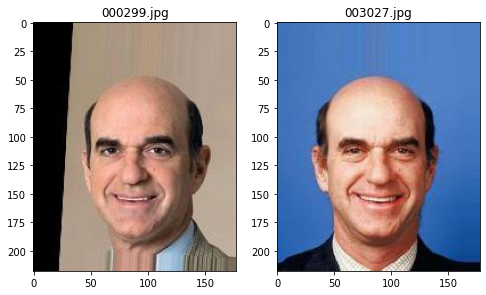

In [ ]:
# images of person from small classes

small_classes = list(df[df['count_img'] < 5].index)
lst_small_classes = df.iloc[random.choice(small_classes)]['imgs'][:5]
show_imgs(lst_small_classes)

### Train Neural Network

Let's build a Datasets and network using this images:

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 

        sample = {
            'image': self.transform(image),
            'label': label,
        }
        
        return (sample['image'], sample['label'])

    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

In [ ]:
transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform2 = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


train_data = celebADataset('train', transform2)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8544
1878
1589
267
59
50


We'll use pretrained on VGGFace2 network InceptionResnetV1 from here: https://github.com/timesler/facenet-pytorch/tree/master/models

In [ ]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 34.71 MiB/s, done.
Resolving deltas: 100% (620/620), done.


In [ ]:
! ls models

inception_resnet_v1.py	mtcnn.py  utils


In [ ]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
model.logits = nn.Linear(in_features=512, out_features=500, bias=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 

**To get the whole mark for this section you need to achieve 80% accuracy on test set**.

In [ ]:
def train(model, train_loader, val_loader, opt, epochs=10):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    loss_fn = nn.CrossEntropyLoss()
    best_model_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('========= Epoch %d/%d =========' % (epoch+1, epochs))        

        # TRAIN
        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            preds = torch.argmax(Y_pred, 1)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            current_train_loss += loss.item() * X_batch.size(0)
            current_train_correct += torch.sum(preds == Y_batch)

        opt.step()

        train_loss = current_train_loss / len(train_data)
        train_losses.append(train_loss)
        train_acc = current_train_correct / len(train_data)
        train_full_acc.append(train_acc)
        print('train loss =', train_loss)
        print('train acc = {:.2f}%'.format(train_acc.item()*100))

        # VALIDATION
        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                X_val = inputs.to(device)
                Y_val = labels.to(device)

                outputs = model(X_val)
                val_loss = loss_fn(outputs, Y_val)
                preds = torch.argmax(outputs, 1)
                current_val_correct += torch.sum(preds == Y_val)
                current_val_loss += val_loss.item() * X_val.size(0)
                
        val_acc = current_val_correct / len(val_data)
        val_loss = current_val_loss / len(val_data)
          
        print('val loss =', val_loss)
        print('val acc = {:.2f}%'.format(val_acc.item() * 100))
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = deepcopy(model.state_dict())
            print('Save new model!')

    return best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc

In [ ]:
EPOCHS = 5
opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()))
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train(model, train_loader, val_loader, opt, epochs=EPOCHS)

========= Epoch 1/5 =========
train loss = 2.5099831197815443
train acc = 60.58%
val loss = 0.6006514517643962
val acc = 91.53%
Save new model!
========= Epoch 2/5 =========
train loss = 0.5167226714922695
train acc = 91.46%
val loss = 0.3897415964494244
val acc = 92.39%
Save new model!
========= Epoch 3/5 =========
train loss = 0.36113597075925785
train acc = 92.95%
val loss = 0.3594437517678014
val acc = 92.97%
Save new model!
========= Epoch 4/5 =========
train loss = 0.2933665748741408
train acc = 93.74%
val loss = 0.44996190445618633
val acc = 89.99%
========= Epoch 5/5 =========
train loss = 0.27872720904899445
train acc = 93.88%
val loss = 0.368923659141833
val acc = 91.80%


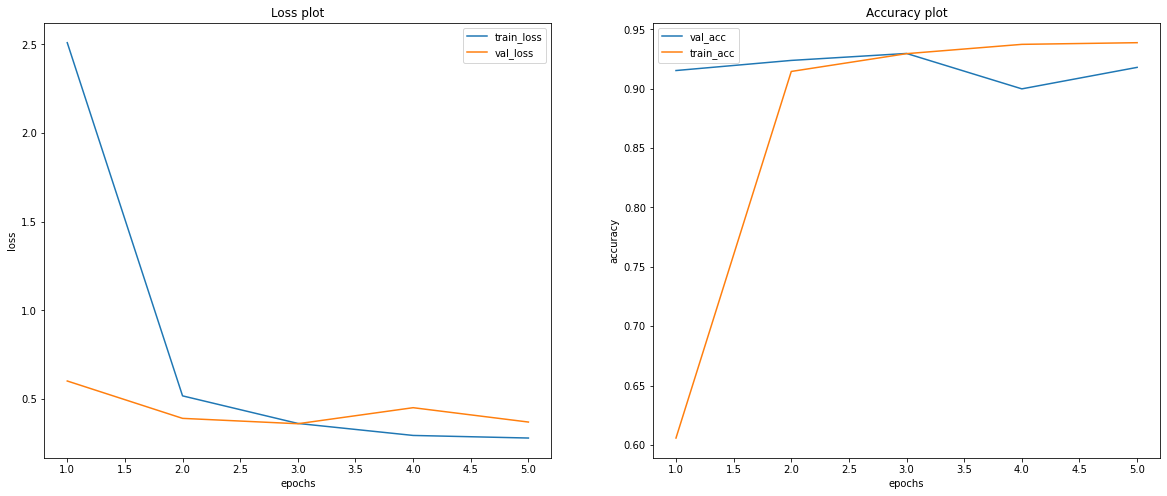

In [ ]:
# SHOW RESULT

fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('Loss plot')
axs[0].plot(list(range(1,EPOCHS+1)), train_losses, label="train_loss")
axs[0].plot(list(range(1,EPOCHS+1)), val_losses, label="val_loss")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")

axs[1].set_title('Accuracy plot')
axs[1].plot(list(range(1,EPOCHS+1)), val_full_acc, label="val_acc")
axs[1].plot(list(range(1,EPOCHS+1)), train_full_acc, label="train_acc")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")

plt.show()

In [ ]:
def test_result(model, test_loader):
    model.eval()
    with torch.no_grad():
        current_test_acc = 0
        for inputs, labels in test_loader:
            X_test = inputs.to(device)
            Y_test = labels.to(device)
            outputs = model(X_test)
            preds = torch.argmax(outputs, 1)
            current_test_acc += torch.sum(Y_test == preds)
    print('Correct answers: {} from {} '\
          .format(current_test_acc, len(test_data)))
    test_acc = current_test_acc / len(test_data)
    print('Test accuracy = {:.2f}%'.format(test_acc*100))

In [ ]:
best_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 500)

best_model.load_state_dict(best_model_weights)

test_result(best_model.to(device), test_loader)

Correct answers: 1460 from 1589 
Test accuracy = 91.88%


**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [ ]:
best_model.classify = False

In [ ]:
best_model.eval()
with torch.no_grad():
    x1 = best_model(train_data.get_photos(0).to(device))
    x2 = best_model(test_data.get_photos(0).to(device))
    x3 = best_model(test_data.get_photos(456).to(device))

In [ ]:
print(cosine_similarity(x1.cpu(), x2.cpu()).mean())  # person 0 from train to person 0 from test (mean value)
print(cosine_similarity(x1.cpu(), x3.cpu()).mean())  # person 0 from train to person 456 from test (mean value)

0.6465007
-0.06419334


In [ ]:
'''
calculate mean cosine similarities for 75 people from train and test
to get heatmap of distribution 
'''

PEOPLE = 75
full_results = []
best_model.eval()
with torch.no_grad():
    for i in range(PEOPLE):
        print('{}/{} person analysis...'.format(i+1,PEOPLE))
        results = []
        x1 = best_model(train_data.get_photos(i).to(device))
        for j in range(PEOPLE):
            if (len((test_data.get_photos(j)) != 0)) and (len((train_data.get_photos(i)) != 0)):
                x2 = best_model(test_data.get_photos(j).to(device))
                results.append(cosine_similarity(x1.cpu(), x2.cpu()).mean())
            else:
                results.append(0.0)
        full_results.append(results)
        clear_output(wait=True)
corr_df = pd.DataFrame(np.array(full_results))
print('Analysis completed! You got {} person\'s mean cosine similarities.'.format(PEOPLE**2))

Analysis completed! You got 5625 person's mean cosine similarities.


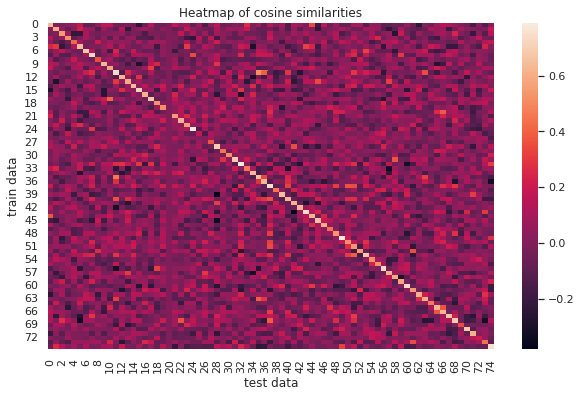

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
fig = sns.heatmap(np.array(full_results))
plt.title('Heatmap of cosine similarities')
plt.xlabel('test data')
plt.ylabel('train data')
plt.show()

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [ ]:
'''
To get more than 5k positive distances, I analyse 50 people and calculate these values for each of them.

For negative pairs I combine person on label (i) and person on label (i+5) - 
it's not unnecessary to choose person on label (i+5) - 
I can take random person which (label != i), but it is easiest way to get more than 5k negative distances.
''';

We got 8589 distances for positive pairs!


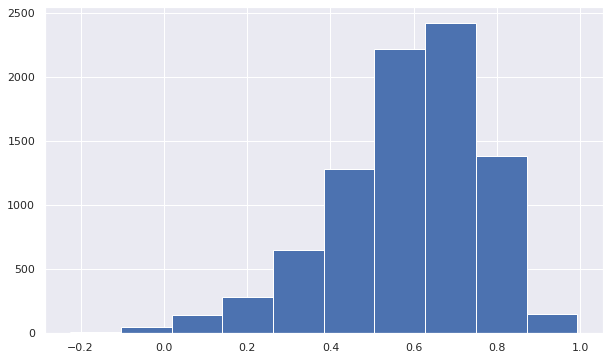

In [ ]:
best_model.eval()
positive_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
      x = best_model(train_data.get_photos(i).to(device))
      myembeddings = pd.DataFrame(cosine_similarity(x.cpu(), x.cpu()))
      myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
      useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)]) # drop nan
      positive_embeddings = torch.cat((positive_embeddings, useful_emb))
print('We got {} distances for positive pairs!'.format(len(positive_embeddings)))

plt.hist(list(positive_embeddings))
plt.show()

We got 8122 distances for negative pairs!


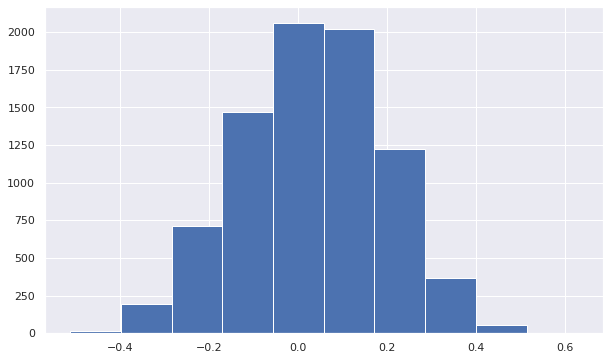

In [ ]:
best_model.eval()
negative_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
      x = best_model(train_data.get_photos(i).to(device))
      x2 = best_model(train_data.get_photos(i+5).to(device))
      myembeddings = pd.DataFrame(cosine_similarity(x.cpu(), x2.cpu()))
      myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
      useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)]) # drop nan
      negative_embeddings = torch.cat((negative_embeddings, useful_emb))
print('We got {} distances for negative pairs!'.format(len(negative_embeddings)))

plt.hist(list(negative_embeddings))
plt.show()

## Task 2 (20% points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary.

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [ ]:
! wget "https://s339vla.storage.yandex.net/rdisk/c2c56cdffbb221d99d9b6fd03f81c384fe941b9aeff8737a30db85a7ef2de65f/6206b271/aZ8Akc9CqtcaAMvg9MkExUS0nM-Qw6vBjH2cBgsvJt4L8iF-6XTumJI9B01yJilqrXxNRYEGr_S1T7X9_fQXiQ==?uid=0&filename=celebA_ir.zip&disposition=attachment&hash=MCgzRvhQiUJarz9o08OG/sEcpdPhcvZdM1R/Ra2e2NF0ybsUoL/BrSQw424Y62pLq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=75566735&hid=5e690094946e8e9da28436cde7a2724a&media_type=compressed&tknv=v2&rtoken=uBEwWnCPIrEf&force_default=no&ycrid=na-d61e23456df02d10bc5ecb03753fd889-downloader10f&ts=5d7c2b04cbe40&s=aa3b38dcb42ce914dffb42ce4295bc3f65607206976f17a3bf9ff07620e30175&pb=U2FsdGVkX19AshTRnUKLFx50tGh_NQA695HOs5XsEbt3Xcg2WSUt8lth-Tsip9-Y7UmDM4gVyAKpTBIdrnoJ-ISJ-XxU4TTwOGxQLlGq4Ys" -O celebA_ir.zip
! unzip celebA_ir.zip

In [ ]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Need to compute embeddings for query
query_img_names = ['./celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = ['./celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('./celebA_ir/celebA_distractors')]

In [ ]:
print(len(distractors_img_names))
print(len(query_img_names))
print(len(query_dict))

23397
7198
300


In [ ]:
class celebA_ir_Dataset(Dataset):
    def __init__(self, images_list, 
                 transform=transforms.Compose([
                                               transforms.Resize(160),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                               ])):
        self.images = images_list
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def get_tensors(self):        
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

    def __getitem__(self, idx):        
        img_name = self.images[idx]
        image = Image.open(img_name) 
        
        return self.transform(image), idx

In [ ]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
  '''
  data = celebA_ir_Dataset(images_list)
  
  model.to(device)

  loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)

  model.eval()
  embeddings = []
  with torch.no_grad():
      for x in loader:
          outputs = model(x.to(device))
          embeddings.append(outputs.cpu())
  return torch.cat(embeddings)

In [ ]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)

In [ ]:
distractors_embeddings.size(), query_embeddings.size()

(torch.Size([23397, 512]), torch.Size([7198, 512]))

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]] 
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
              )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)
          
          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
          useful_result = df[~np.isnan(df)] # drop nan

          useful_result = torch.Tensor(useful_result).view(-1)
          full_embeddings = torch.cat((full_embeddings, useful_result))
  results = [i.item() for i in full_embeddings]
  plt.hist(results)
  plt.show()
  print('Count of cosine similarities =', len(results))
  return results

# test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
#                                             test_query_embeddings)

In [ ]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()
  class_counter = []

  k = 0
  for person_class in query_dict:
      k += 1
      print('Analyse {} person of {}...'.format(k, len(query_dict)))
      images = [PATH.format(x) for x in query_dict[person_class]] 
      class_counter.extend([person_class for i in range(len(images))])

      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          full_embeddings = torch.cat((full_embeddings, person_embeddings))
      clear_output(wait=True)

  all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
  results = cosine_similarity(full_embeddings, full_embeddings)
  results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

  k = 0
  for i in results:
      k += 1
      print('Analyse {} row of {}...'.format(k, len(results)))
      results.loc[i, i] = np.nan
      clear_output(wait=True)

  df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
  useful_result = df[~np.isnan(df)] # drop nan
  plt.hist(useful_result)
  plt.show()
  print('Count of cosine similarities =', len(useful_result))
  return useful_result

# test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
#                                             test_query_embeddings)

In [ ]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  results = cosine_similarity(query_embeddings, distractors_embeddings)
  results = results.reshape(-1)
  plt.hist(results)
  plt.show()
  print('Count of cosine similarities =', len(results))
  return results

# test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
#                                                             test_distractors_embeddings)

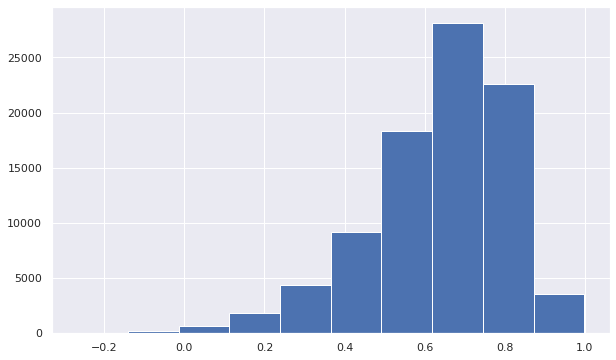

Count of cosine similarities = 88952


In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)

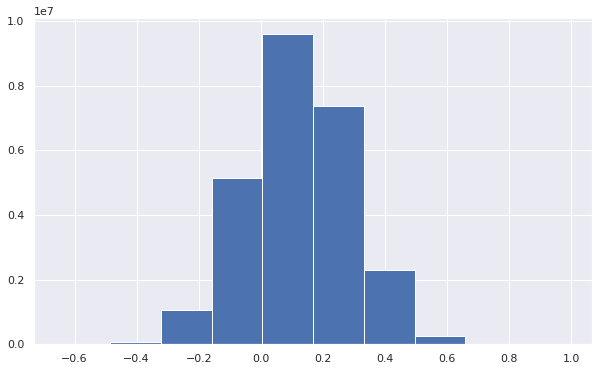

Count of cosine similarities = 25813051


In [ ]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                             query_embeddings)

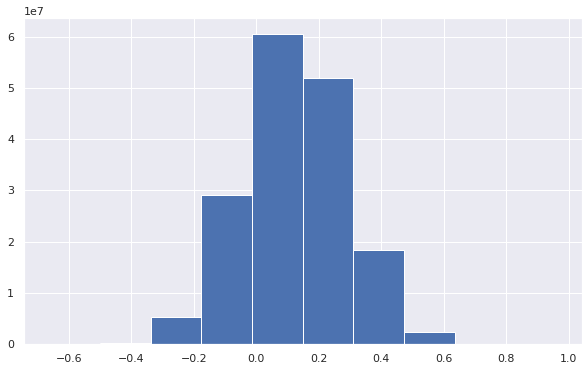

Count of cosine similarities = 168411606


In [ ]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)

Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

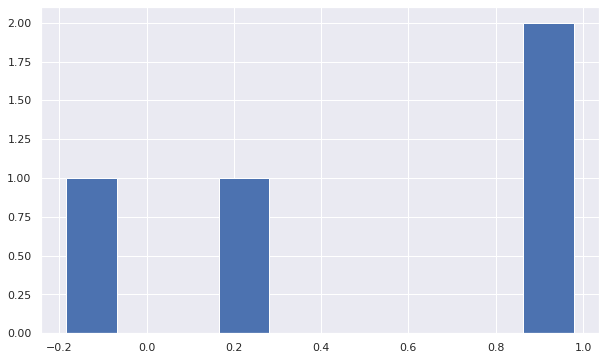

Count of cosine similarities = 4


In [ ]:
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)

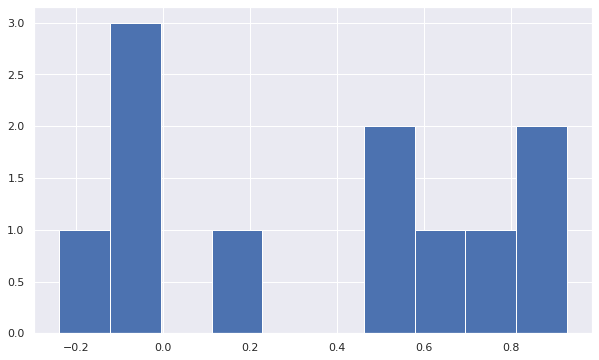

Count of cosine similarities = 11


In [ ]:
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)

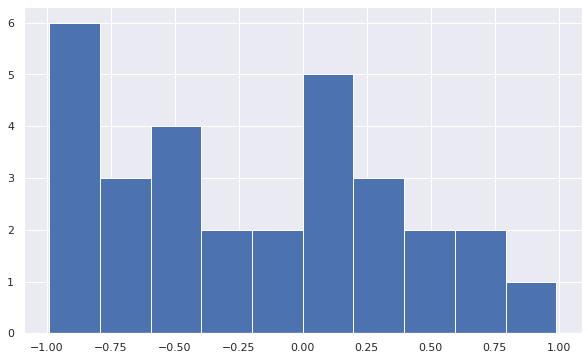

Count of cosine similarities = 30


In [ ]:
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output: 
    float: threshold for given fpr 
    float: TPR at given FPR
  '''
  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  N = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending = True)[0]
  threshold = false_pairs[N]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
  return threshold.item(), TPR

# compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
#                     test_cosine_query_distractors, fpr=0.1)

Check yourself:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
all_thr = []
all_tpr = []

for fpr in [0.5, 0.2, 0.1, 0.05]:
    print('Analyse by fpr = {}'.format(fpr))
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                      cosine_query_distractors, fpr=fpr)
    all_thr.append(x)
    all_tpr.append(y)
    clear_output(wait=True)

print(all_thr)
print(all_tpr)

[0.12065773457288742, 0.2599410116672516, 0.3320732116699219, 0.39078259468078613]
[0.9887917078873999, 0.963058728302905, 0.9361003687381959, 0.9046789279611476]


## Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

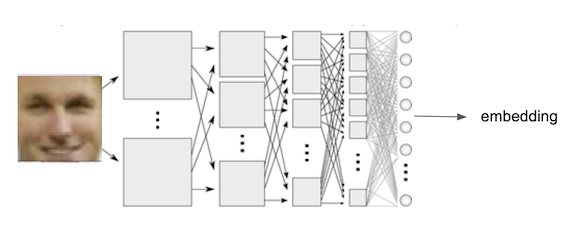

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [ ]:
class TripletLoss_celebADataset(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type
        
        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()

        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}

        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform
        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        triplet_df = pd.DataFrame(columns=['label', 'positives', 'negatives'])

        for label in trange(500):
            negatives = list(self.df[self.df.label != label].original.values)
            positives = list(self.df[self.df.label == label].original.values)
            triplet_df = triplet_df.append({'label': label,'positives': positives, 'negatives': negatives}, ignore_index=True)
        self.triplet_df = triplet_df
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        anchor = self.images[idx]
        anchor_tensor = self.transform(Image.open(anchor))
        
        if self.dataset_type in ['train', 'val']:
            all_positives = self.triplet_df[self.triplet_df.label == label].positives.values[0] 
            all_negatives = self.triplet_df[self.triplet_df.label == label].negatives.values[0] 

            positive = random.choice(all_positives)
            negative = random.choice(all_negatives)

            positive_tensor = self.transform(Image.open(positive))
            negative_tensor = self.transform(Image.open(negative))
 
            return anchor_tensor, positive_tensor, negative_tensor, label
        else:
            return anchor_tensor, label

In [ ]:
train_TripletLoss = TripletLoss_celebADataset('train', transform2)
val_TripletLoss = TripletLoss_celebADataset('val', transform)
test_TripletLoss = TripletLoss_celebADataset('test', transform)

100%|██████████| 500/500 [00:01<00:00, 250.64it/s]


In [ ]:
batch_size = 32
train_TripletLoss_loader = torch.utils.data.DataLoader(train_TripletLoss, batch_size=batch_size, shuffle=True)
val_TripletLoss_loader = torch.utils.data.DataLoader(val_TripletLoss, batch_size=batch_size, shuffle=False)
test_TripletLoss_loader = torch.utils.data.DataLoader(test_TripletLoss, batch_size=batch_size, shuffle=False)

In [ ]:
def train_TL(model, train_loader, val_loader, opt, epochs=10, MARGIN=1.0):
    train_losses, val_losses, val_full_acc = [], [], []
    best_acc = 0.0

    triplet_loss = nn.TripletMarginWithDistanceLoss(
        distance_function = lambda x,y: 1.0 - F.cosine_similarity(x,y),
        margin = MARGIN
        )
    
    best_TL_weights = deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('========= Epoch %d/%d =========' % (epoch+1, epochs))        
        # TRAIN
        model.train()
        current_train_loss = 0

        for anchor, positive, negative, label in train_loader:
            # forward
            opt.zero_grad()

            anchor_emb = model(anchor.to(device))
            positive_emb = model(positive.to(device))
            negative_emb = model(negative.to(device))
          
            output = triplet_loss(anchor_emb, positive_emb, negative_emb)

            # backward
            output.backward()
            opt.step()

            current_train_loss += output.item()

        train_loss = current_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print('Train loss: {:.4f}'.format(train_loss))
      

        # GET MEAN EMBEDDINGS FOR ACCURACY ASSESSMENT
        model.eval()
        with torch.no_grad():
            for label in trange(500):
                positives = list(train_TripletLoss.df[train_TripletLoss.df.label == label].original.values)
                label_tensors = torch.stack([train_TripletLoss.transform(Image.open(i)) for i in positives])
                label_embedding = model(label_tensors.to(device)) 
                label_embedding = label_embedding.cpu().detach().numpy() 
                label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
                if label == 0:
                    list_embeddings = label_mean_embedding
                    continue
                list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)

        # VALIDATION
        model.eval()

        current_val_loss = 0
        current_val_correct = 0

        with torch.no_grad():
            for anchor, positive, negative, label in val_loader:
                anchor_emb = model(anchor.to(device))
                positive_emb = model(positive.to(device))
                negative_emb = model(negative.to(device))

                output = triplet_loss(anchor_emb, positive_emb, negative_emb)
                
                cos = cosine_similarity(anchor_emb.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1)
                current_val_loss += output.item()
                current_val_correct += torch.sum(result == label).item()

        val_loss = current_val_loss / len(val_loader)
        val_acc = current_val_correct / len(val_TripletLoss)
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        print('Val loss: {:.4f}'.format(val_loss))
        print('You guessed {} of {} labels'.format(current_val_correct, len(val_TripletLoss)))
        print('Val accuracy: {:.4f}%'.format(val_acc*100))

        if val_acc > best_acc:
            best_acc = val_acc
            best_TL_weights = deepcopy(model.state_dict())
            print('Save new model!')

    return best_TL_weights, train_losses, val_losses, val_full_acc

In [ ]:
def get_list_embeddings(model):
    model.eval()
    with torch.no_grad():
        for label in trange(500):
            positives = list(train_TripletLoss.df[train_TripletLoss.df.label == label].original.values)
            label_tensors = torch.stack([train_TripletLoss.transform(Image.open(i)) for i in positives])
            label_embedding = model(label_tensors.to(device))
            label_embedding = label_embedding.cpu().detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
            if label == 0:
                  list_embeddings = label_mean_embedding
                  continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    return list_embeddings


def test_triplet(model, test_loader, list_embeddings):
    model.eval()
    with torch.no_grad():
        current_correct = 0
        for anchor, label in test_loader:
            anchor_emb = model(anchor.to(device)).cpu()
            cos = cosine_similarity(anchor_emb.detach().numpy(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1)
            current_correct += torch.sum(result == label).item()
    test_acc = current_correct / len(test_TripletLoss)
    return current_correct, test_acc

In [ ]:
models_info = {}
EPOCHS = 5
for MARGIN in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    print('Testing MARGIN = {}'.format(MARGIN))

    # LOADING MODEL
    TripletLoss_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)

    for param in TripletLoss_model.parameters():
        param.requires_grad = False

    TripletLoss_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
    TripletLoss_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

    TripletLoss_model.to(device); 

    # START TRAINING
    opt = optim.AdamW(filter(lambda p: p.requires_grad, TripletLoss_model.parameters()))
    best_TL_weights, train_loss_TL, val_loss_TL, acc_TL = train_TL(TripletLoss_model, train_TripletLoss_loader, val_TripletLoss_loader, opt, epochs=EPOCHS, MARGIN=MARGIN)

    models_info[MARGIN] = [best_TL_weights, train_loss_TL, val_loss_TL, acc_TL]

    # SAVE BEST MODEL
    best_TL = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
    best_TL.load_state_dict(best_TL_weights)

    # TEST BEST MODEL
    print('Start testing')
    list_embeddings = get_list_embeddings(best_TL.to(device))
    current_correct, test_acc = test_triplet(best_TL.to(device), test_TripletLoss_loader, list_embeddings)    
    models_info[MARGIN].extend([current_correct, test_acc])
    print('You guessed {} of {} labels'.format(current_correct, len(test_TripletLoss)))
    print('Test accuracy: {:.3f}%'.format(test_acc * 100))
    print()

In [ ]:
margin_df = pd.DataFrame()
for i in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    margin_df = margin_df.append({'test accuracy': models_info[i][1:][-1]}, ignore_index=True)
margin_df.index = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
margin_df = margin_df.T
margin_df['best accuracy'] = max(margin_df.loc['test accuracy'])

In [ ]:
margin_df

0.5       0.6       0.7  ...       0.9       1.0  best accuracy
test accuracy  0.884204  0.859031  0.836375  ...  0.786658  0.748899       0.884204

[1 rows x 7 columns]

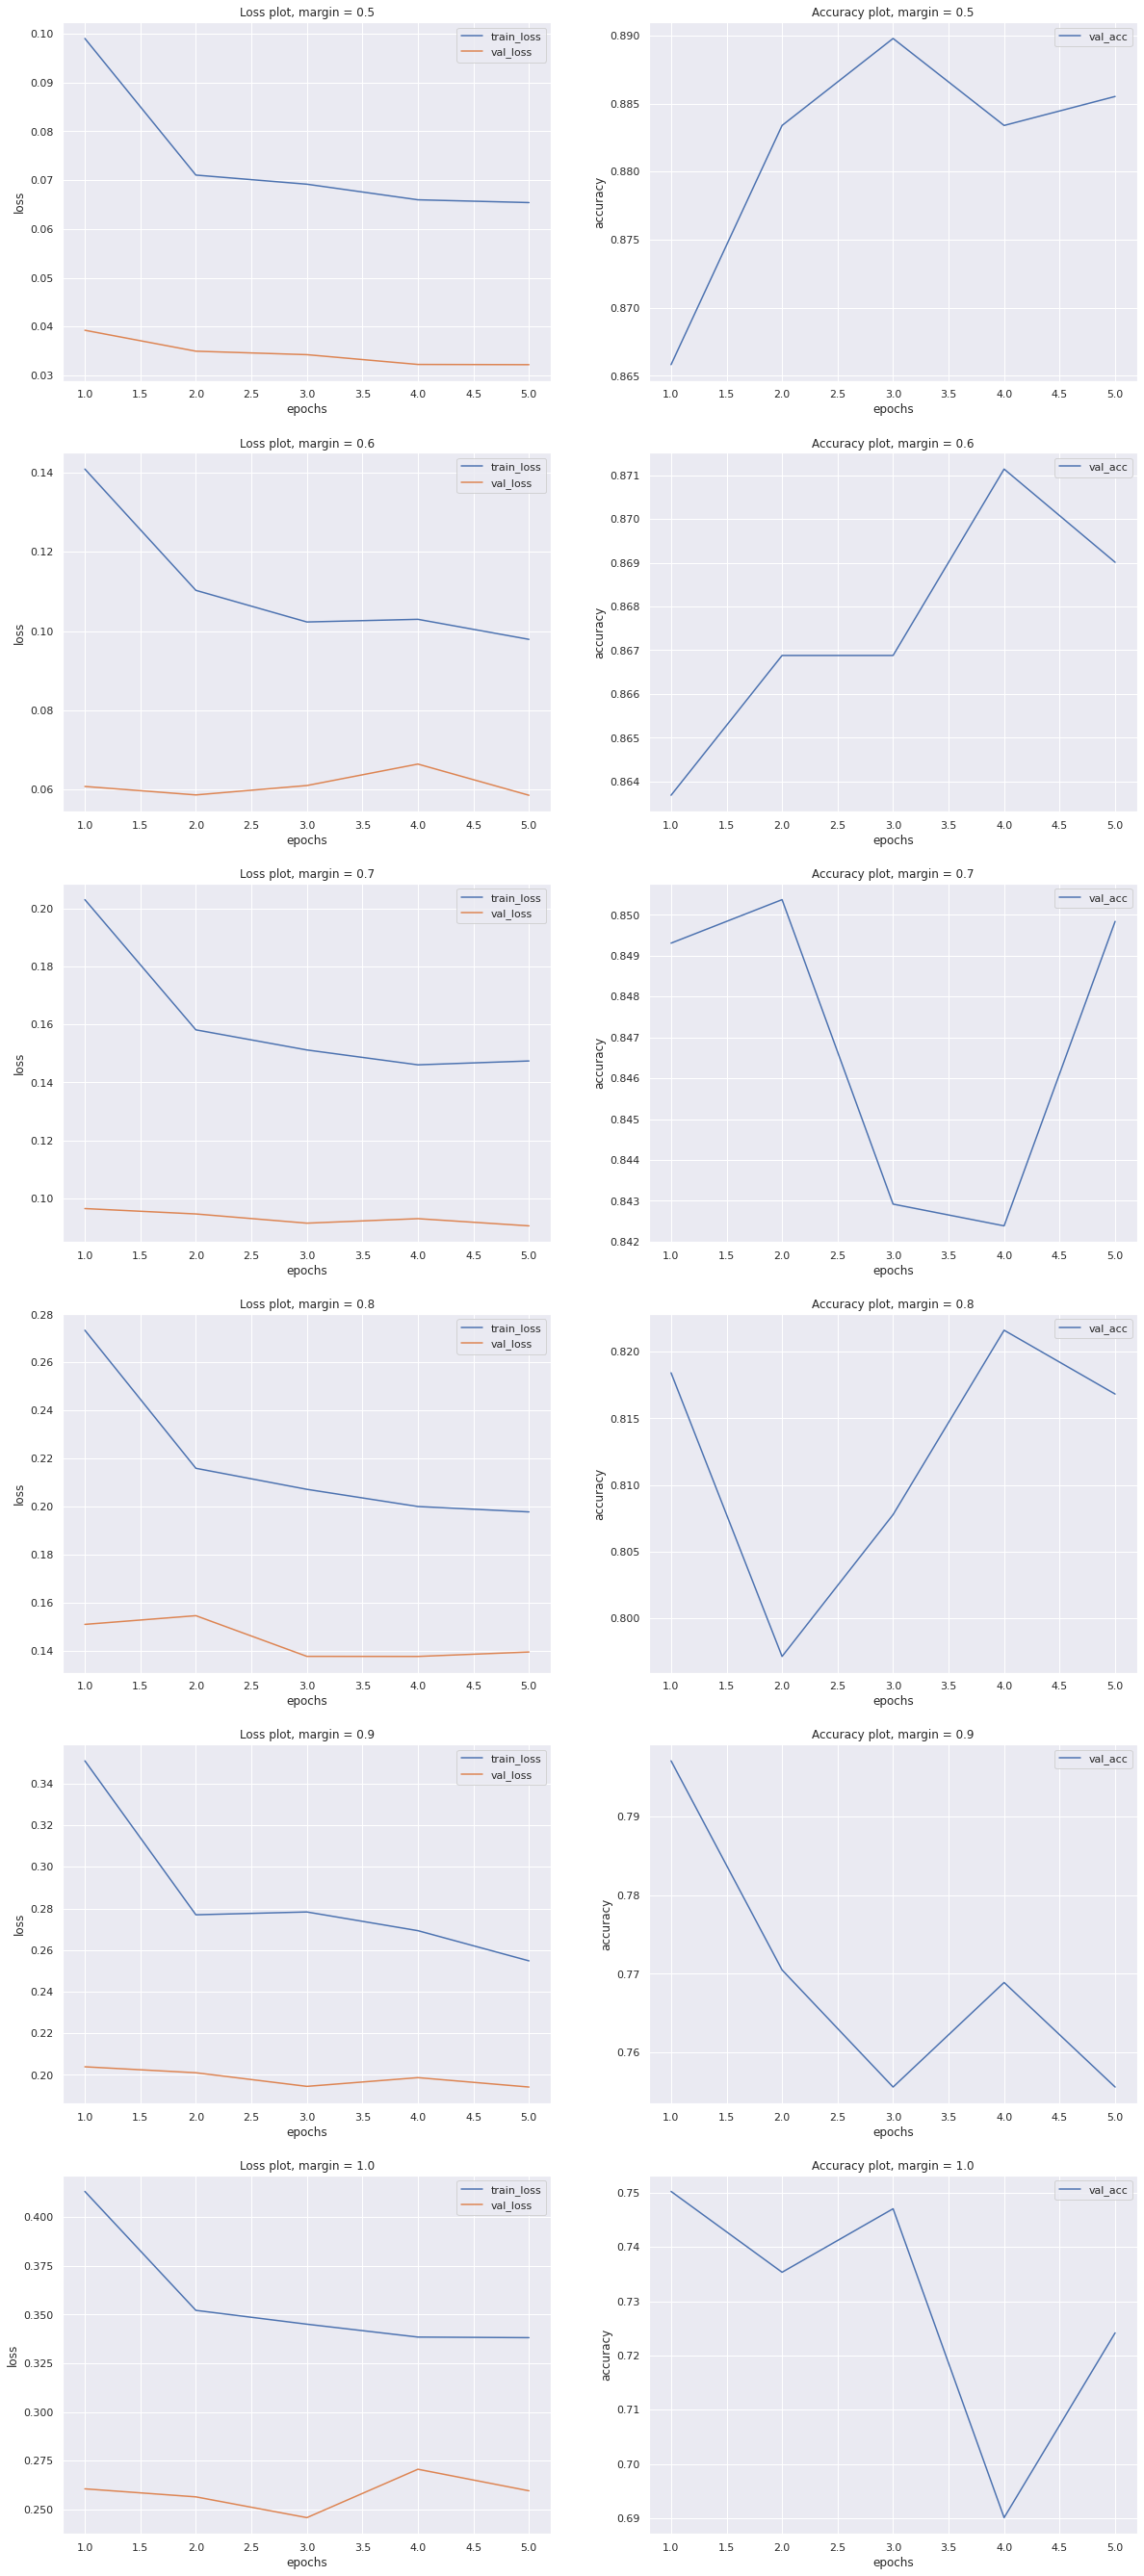

In [ ]:
# SHOW RESULT
fig, axs = plt.subplots(6, 2, figsize=(20,48))
for i, MARGIN in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    train_loss_TL = models_info[MARGIN][1]
    val_loss_TL = models_info[MARGIN][2]
    acc_TL = models_info[MARGIN][3]
    axs[i,0].set_title('Loss plot, margin = {}'.format(MARGIN))
    axs[i,0].plot(list(range(1,EPOCHS+1)), train_loss_TL, label="train_loss")
    axs[i,0].plot(list(range(1,EPOCHS+1)), val_loss_TL, label="val_loss")
    axs[i,0].legend()
    axs[i,0].set_xlabel("epochs")
    axs[i,0].set_ylabel("loss")
        
    axs[i,1].set_title('Accuracy plot, margin = {}'.format(MARGIN))
    axs[i,1].plot(list(range(1,EPOCHS+1)), acc_TL, label="val_acc")
    axs[i,1].legend()
    axs[i,1].set_xlabel("epochs")
    axs[i,1].set_ylabel("accuracy")

plt.show()

### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.

In [ ]:
class ArcFace_celebADataset(Dataset):

    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform

        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        arcface_df = pd.DataFrame(columns=['label', 'positives'])

        for label in trange(500):
            positives = list(self.df[self.df.label == label].original.values)
            arcface_df = arcface_df.append({'label': label,'positives': positives}, ignore_index=True)
        self.arcface_df = arcface_df

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 

        sample = {'image': self.transform(image),
                  'label': label}

        return (sample['image'], sample['label'])


In [ ]:
train_ArcFace_data = ArcFace_celebADataset('train', transform2)
val_ArcFace_data = ArcFace_celebADataset('val', transform)
test_ArcFace_data = ArcFace_celebADataset('test', transform)

batch_size = 32
train_ArcFace_loader = torch.utils.data.DataLoader(train_ArcFace_data, batch_size=batch_size, shuffle=True)
val_ArcFace_loader = torch.utils.data.DataLoader(val_ArcFace_data, batch_size=batch_size, shuffle=False)
test_ArcFace_loader = torch.utils.data.DataLoader(test_ArcFace_data, batch_size=batch_size, shuffle=False)

100%|██████████| 500/500 [00:01<00:00, 294.23it/s]


In [ ]:
class ArcFace_Loss(nn.Module):
    def __init__(self, in_f, out_f, s=None, m=None, eps=1e-7):
        super(ArcFace_Loss, self).__init__()

        self.s = 64.0 if not s else s
        self.m = 0.5 if not m else m
        
        self.fc = nn.Linear(in_f, out_f, bias=False)
        self.eps = eps

    def forward(self, logits, labels):
        ''' 
        logits: tensor(...) => [32, 512]
        labels: tensor([338, 317, ...]) => [32]
        '''
        for W in self.fc.parameters():
            W = F.normalize(W) # normalized weights 

        x = F.normalize(logits)  # normalized embeddings (feature) => [32, 512]      
        wf = self.fc(x)   # outputs of ArcFace Linear Layer => [32, 500]
        
        '''
        wf.transpose(0, 1) -- wf.T => [500, 32] {1}
        {1}[labels]  -- get rows by number 'label' from {1} => [32. 32] {2}
        torch.diagonal({2}) -- get diagonal values from {2} => [32] {3}
        torch.acos({3}) -- angle between the feature x_i and the ground truth weight W_y_i => [32]
        '''
        
        numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)

        '''
        [torch.cat((wf[i, :y], wf[i, y+1:])) for i, y in enumerate(labels)] => np.array (32,)
        numerator => [32]
        excl => [32, 499]
        denominator => [32]
        '''

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)

        L = numerator - torch.log(denominator)

        return -torch.mean(L)

In [ ]:
'''
install this library if you want train model on prepared arcface loss
''';
# !pip install pytorch_metric_learning
# from pytorch_metric_learning import losses

In [ ]:
def train_AF(model, train_loader, val_loader, opt, epochs=10):
    train_losses, val_losses, val_full_acc = [], [], []
    best_acc = 0.0
    loss_fn = ArcFace_Loss(512, 500, s=15, m=0.01).to(device)
    # loss_fn = losses.ArcFaceLoss(500, 512, margin=0.01, scale=15)  # prepared loss
    best_AF_weights = deepcopy(model.state_dict())
    loss_optimizer = torch.optim.AdamW(loss_fn.parameters(), lr=0.01)

    for epoch in range(epochs):
        print('========= Epoch %d/%d =========' % (epoch+1, epochs))        

        # TRAIN
        model.train()
        current_train_loss = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(device)
            Y_batch = labels.to(device)

            # forward
            opt.zero_grad()
            loss_optimizer.zero_grad()
            Y_pred = model(X_batch).to(device)
            loss = loss_fn(Y_pred, Y_batch)

            # backward
            loss.backward()

            opt.step()
            loss_optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)

        train_loss = current_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print('Train loss: {:.4f}'.format(train_loss))

        # GET MEAN EMBEDDINGS FOR ACCURACY ASSESSMENT
        model.eval()
        with torch.no_grad():
            for label in trange(500):
                positives = list(train_ArcFace_data.df[train_ArcFace_data.df.label == label].original.values)
                label_tensors = torch.stack([train_ArcFace_data.transform(Image.open(i)) for i in positives])
                label_embedding = model(label_tensors.to(device)) 
                label_embedding = label_embedding.cpu().detach().numpy()
                label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
                if label == 0:
                    list_embeddings = label_mean_embedding
                    continue
                list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)

        # VALIDATION
        model.eval()

        current_val_loss = 0
        current_val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                Y_pred = model(inputs.to(device))
                Y_val = labels.to(device)

                output = loss_fn(Y_pred, Y_val)
                
                cos = cosine_similarity(Y_pred.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1).to(device)
                current_val_loss += output.item()
                current_val_correct += torch.sum(result == Y_val).item()
                
        val_loss = current_val_loss / len(val_loader)
        val_acc = current_val_correct / len(val_ArcFace_data)
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)
          
        print('Val loss: {:.4f}'.format(val_loss))
        print('You guessed {} of {} labels'.format(current_val_correct, len(val_ArcFace_data)))
        print('Val accuracy: {:.4f}%'.format(val_acc*100))

        if val_acc > best_acc:
            best_acc = val_acc
            best_AF_weights = deepcopy(model.state_dict())
            print('Save new model!')

    return best_AF_weights, train_losses, val_losses, val_full_acc

In [ ]:
Arcface_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)

for param in Arcface_model.parameters():
    param.requires_grad = False

Arcface_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
Arcface_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

Arcface_model.to(device);

In [ ]:
EPOCHS = 5
opt = optim.AdamW(filter(lambda p: p.requires_grad, Arcface_model.parameters()))
best_AF_weights, train_loss_AF, val_loss_AF, acc_AF = train_AF(Arcface_model, train_ArcFace_loader, val_ArcFace_loader, opt, epochs=EPOCHS)

========= Epoch 1/5 =========
Train loss: 73.9349


100%|██████████| 500/500 [00:29<00:00, 16.85it/s]


Val loss: 1.6545
You guessed 1760 of 1878 labels
Val accuracy: 93.7167%
Save new model!
========= Epoch 2/5 =========
Train loss: 52.6350


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]


Val loss: 1.8114
You guessed 1750 of 1878 labels
Val accuracy: 93.1842%
========= Epoch 3/5 =========
Train loss: 55.4245


100%|██████████| 500/500 [00:29<00:00, 16.74it/s]


Val loss: 1.6660
You guessed 1769 of 1878 labels
Val accuracy: 94.1960%
Save new model!
========= Epoch 4/5 =========
Train loss: 50.7026


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]


Val loss: 1.2770
You guessed 1765 of 1878 labels
Val accuracy: 93.9830%
========= Epoch 5/5 =========
Train loss: 41.5437


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]


Val loss: 1.1957
You guessed 1753 of 1878 labels
Val accuracy: 93.3440%


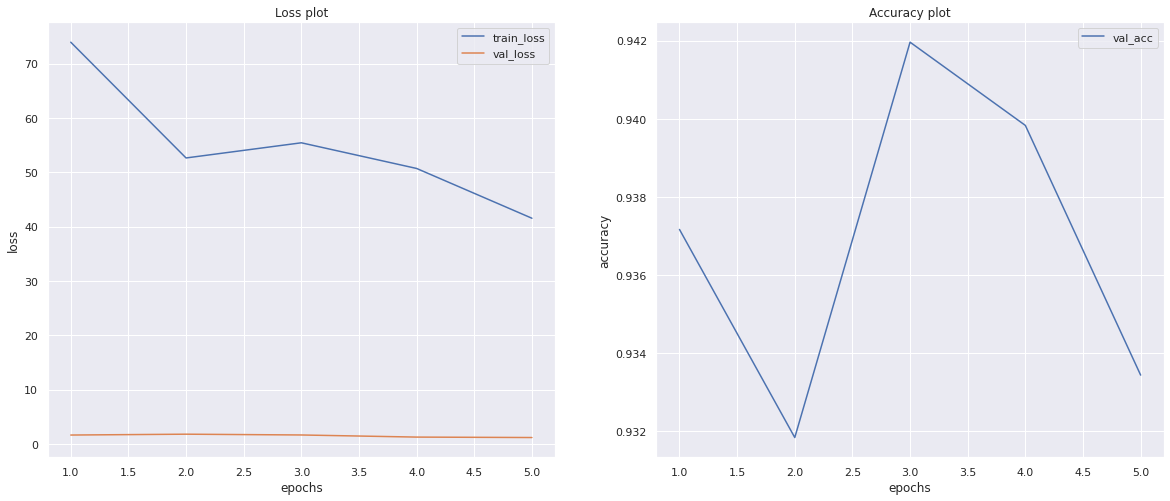

In [ ]:
# SHOW RESULT

fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('Loss plot')
axs[0].plot(list(range(1,EPOCHS+1)), train_loss_AF, label="train_loss")
axs[0].plot(list(range(1,EPOCHS+1)), val_loss_AF, label="val_loss")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")

axs[1].set_title('Accuracy plot')
axs[1].plot(list(range(1,EPOCHS+1)), acc_AF, label="val_acc")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")

plt.show()

In [ ]:
def get_list_embeddings_AC(model):
    model.eval()
    with torch.no_grad():
        for label in trange(500):
            positives = list(train_ArcFace_data.df[train_ArcFace_data.df.label == label].original.values)
            label_tensors = torch.stack([train_ArcFace_data.transform(Image.open(i)) for i in positives])
            label_embedding = model(label_tensors.to(device)) 
            label_embedding = label_embedding.cpu().detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
            if label == 0:
                list_embeddings = label_mean_embedding
                continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    return list_embeddings

def test_AC(model, test_loader, list_embeddings):
    model.eval()
    with torch.no_grad():
        current_correct = 0
        for inputs, labels in test_loader:
            Y_pred = model(inputs.to(device))
            Y_test = labels.to(device)
                
            cos = cosine_similarity(Y_pred.cpu(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1).to(device)
            current_correct += torch.sum(result == Y_test).item()

    test_acc = current_correct / len(test_ArcFace_data)
    return current_correct, test_acc

In [ ]:
# SAVE BEST MODEL
best_AC = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
best_AC.load_state_dict(best_AF_weights)

# TEST BEST MODEL
list_embeddings = get_list_embeddings_AC(best_AC.to(device))
current_correct, test_acc = test_AC(best_AC.to(device), test_ArcFace_loader, list_embeddings)    

print('You guessed {} of {} labels'.format(current_correct, len(test_ArcFace_data)))
print('Test accuracy: {:.3f}%'.format(test_acc * 100))

100%|██████████| 500/500 [00:29<00:00, 16.92it/s]


You guessed 1487 of 1589 labels
Test accuracy: 93.581%


## Bonus task (5% points): Finding trash photos 

You have probably noticed that in identification rate calculation we use cosine similarity between embeddings, which includes embeddings' normalization. And in TripletLoss also we normalize embeddings before passing them to the loss. Actually this is how most of the face recognition algorithms work — they are designed to output a normalized embeddings and any comparison between embeddings is done after the embeddings are normalized. Sometimes it may be beneficial even to add a normalization layer (batchnorm or layernorm with fixed parameters) after the model's embedding layer to make the model output normalized embeddings.

But norms of the unnormalized embeddings can also be used. They can be used to detect trash photos — photos, where the face is presented really badly (e.g. back of the head instead of the forehead or even a photo without any head that has appeared in a dataset due to a mistake in face detection / landmarks detection algorithm).

Empirically it has been found that the higher the embedding's norm, the more the probability of the corresponding photo to be trash is. 



**Task**: get the embeddings of photos in a test set / query set / distractors set. Sort them by their norms. Output the photos whose embeddings norms are the highest. Do they look like normal or trash?

**Doing this task will not give you points above 100% for the whole homework. But if you have any mistakes in previous sections, doing this task may give you additional points (5% of total points) to cover points lost.**

In [ ]:
transform_t = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform2_t = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_trash_data = ArcFace_celebADataset('train', transform2_t)
val_trash_data = ArcFace_celebADataset('val', transform_t)
test_trash_data = ArcFace_celebADataset('test', transforms.Compose([transforms.Resize(160),
                                                                    transforms.ToTensor(),
                                                                    ]))

train_trash_loader = torch.utils.data.DataLoader(train_trash_data, batch_size=batch_size, shuffle=True)
val_trash_loader = torch.utils.data.DataLoader(val_trash_data, batch_size=batch_size, shuffle=False)
test_trash_loader = torch.utils.data.DataLoader(test_trash_data, batch_size=batch_size, shuffle=False)

100%|██████████| 500/500 [00:01<00:00, 298.05it/s]


In [ ]:
trash_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=500)

for param in trash_model.parameters():
    param.requires_grad = False

trash_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
trash_model.last_bn = nn.Identity()
trash_model.logits = nn.Identity()

trash_model.to(device);

In [ ]:
EPOCHS = 3
opt = optim.AdamW(filter(lambda p: p.requires_grad, trash_model.parameters()))
best_trash_weights, train_loss_trash, val_loss_trash, acc_trash = \
    train_AF(trash_model, train_trash_loader, val_trash_loader, opt, epochs=EPOCHS)

========= Epoch 1/3 =========
Train loss: 75.3921


100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


Val loss: 1.1768
You guessed 1761 of 1878 labels
Val accuracy: 93.7700%
Save new model!
========= Epoch 2/3 =========
Train loss: 52.0766


100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


Val loss: 1.0669
You guessed 1772 of 1878 labels
Val accuracy: 94.3557%
Save new model!
========= Epoch 3/3 =========
Train loss: 49.3155


100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


Val loss: 1.1096
You guessed 1764 of 1878 labels
Val accuracy: 93.9297%


In [ ]:
best_trash = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=500)
best_trash.last_bn = nn.Identity()
best_trash.logits = nn.Identity()

best_trash.load_state_dict(best_trash_weights)

best_trash.to(device);

In [ ]:
def get_list_norms_trash(trash_model, test_loader):
    trash_model.eval()
    list_embeddings = torch.Tensor()
    with torch.no_grad():
        for inputs, _ in tqdm(test_loader):
            embeddings = trash_model(inputs.to(device))
            if len(list_embeddings) == 0:
                list_embeddings = embeddings
                continue
            list_embeddings = torch.cat((list_embeddings, embeddings), 0)
        list_norm = torch.norm(list_embeddings, dim=1)
    return torch.sort(list_norm)

test_trash_result = get_list_norms_trash(best_trash, test_trash_loader)

100%|██████████| 50/50 [00:04<00:00, 10.76it/s]


In [ ]:
query_trash_embeddings = compute_embeddings(best_trash, query_img_names)
distractors_trash_embeddings = compute_embeddings(best_trash, distractors_img_names)

trash_result_query = torch.sort(torch.norm(query_trash_embeddings, dim=1))
trash_result_distractors = torch.sort(torch.norm(distractors_trash_embeddings, dim=1))

In [ ]:
ind_test = test_trash_result[1]
ind_query = trash_result_query[1]
ind_distractors = trash_result_distractors[1]

print(test_trash_result)
print()
print(trash_result_query)
print()
print(trash_result_distractors)

torch.return_types.sort(
values=tensor([ 6.4044,  6.6001,  6.7826,  ..., 12.0687, 12.1150, 12.2138],
       device='cuda:0'),
indices=tensor([  31,  486,  730,  ..., 1574, 1342,  413], device='cuda:0'))

torch.return_types.sort(
values=tensor([ 7.3440,  7.5478,  7.9847,  ..., 13.3288, 13.3631, 13.3716]),
indices=tensor([ 206, 2451, 2459,  ..., 5298, 1311, 7037]))

torch.return_types.sort(
values=tensor([ 7.1240,  7.6634,  7.7985,  ..., 13.8095, 13.8939, 14.1730]),
indices=tensor([13371,  5417,  6832,  ..., 18305, 10844, 10926]))


In [ ]:
def get_indic(lenght, key, current_ind):
    while lenght > 0:
        if key == 'small':
            yield current_ind[:12][lenght-1] # first 12
        elif key == 'high':
            yield current_ind[-12:][lenght-1] # last 12
        lenght -= 1

In [ ]:
def get_trash_photo(ind, data):
    indic = get_indic(12, 'small', ind)
    fig, axs = plt.subplots(2,5,figsize=(15,6))
    fig.suptitle('Smallest norm', fontsize=20)
    for ax_row in axs:
      for i in ax_row:
        current_ind = next(indic).item()
        i.imshow((data.__getitem__(current_ind))[0].permute(1,2,0))
        i.grid(False)
        i.set_title(current_ind)
        i.set_xticks([])
        i.set_yticks([])

    indic = get_indic(12, 'high', ind)
    fig, axs = plt.subplots(2,5,figsize=(15,6))
    fig.suptitle('Highest norm', fontsize=20)
    for ax_row in axs:
      for i in ax_row:
        current_ind = next(indic).item()
        i.imshow((data.__getitem__(current_ind))[0].permute(1,2,0))
        i.grid(False)
        i.set_title(current_ind)
        i.set_xticks([])
        i.set_yticks([])

In [ ]:
query_trash_data = celebA_ir_Dataset(query_img_names,\
                                     transform=transforms.Compose([transforms.Resize(160),
                                                                    transforms.ToTensor(),
                                                                    ]))
distractors_trash_data = celebA_ir_Dataset(distractors_img_names,\
                                           transform=transforms.Compose([transforms.Resize(160),
                                                                         transforms.ToTensor(),
                                                                         ]))

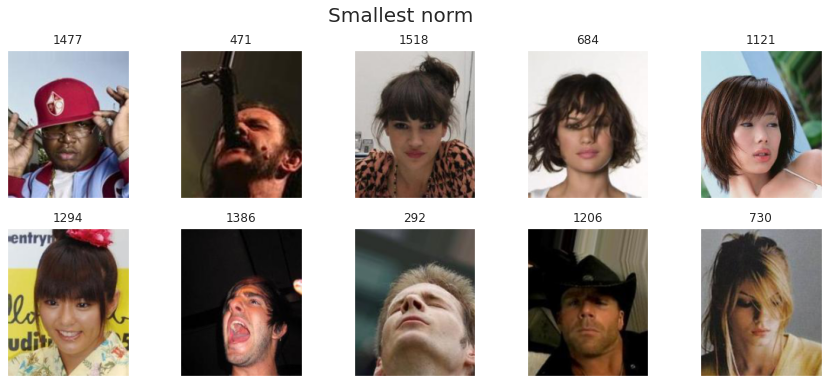

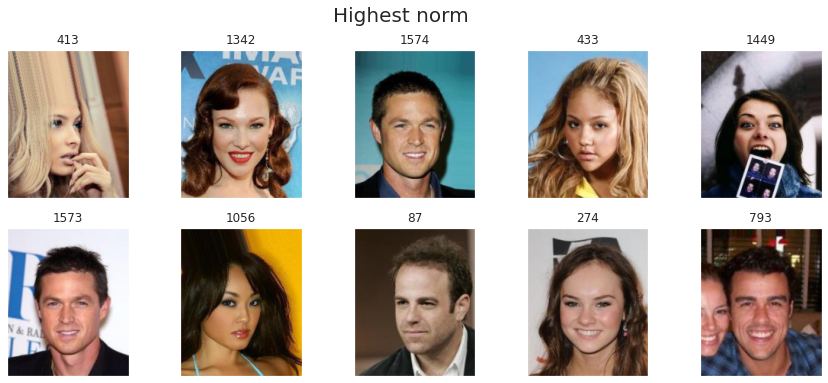

In [ ]:
# Trash in test

get_trash_photo(ind_test, test_trash_data)

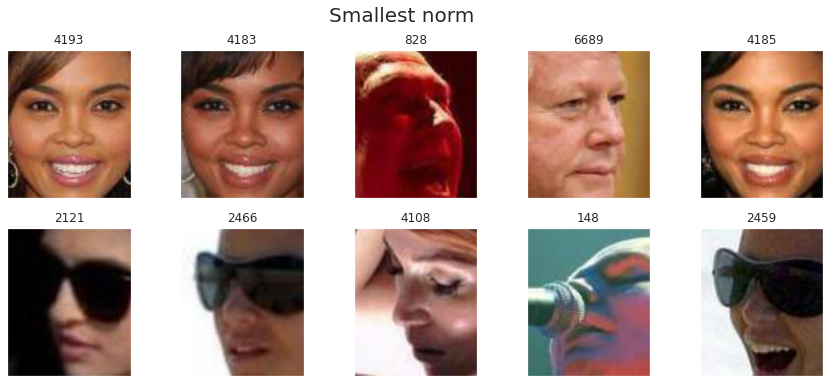

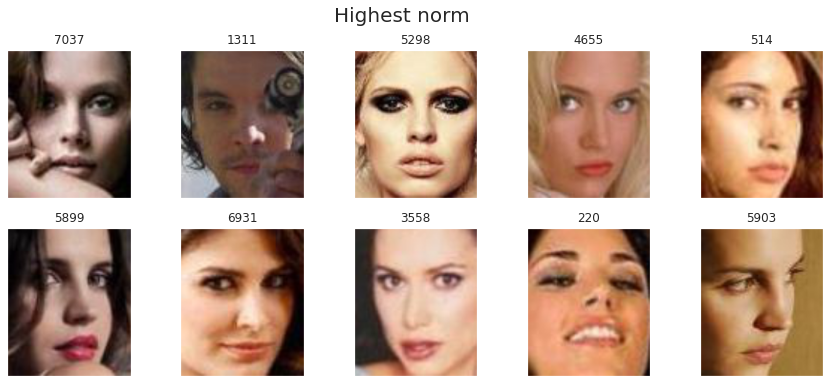

In [ ]:
# Trash in query

get_trash_photo(ind_query, query_trash_data)

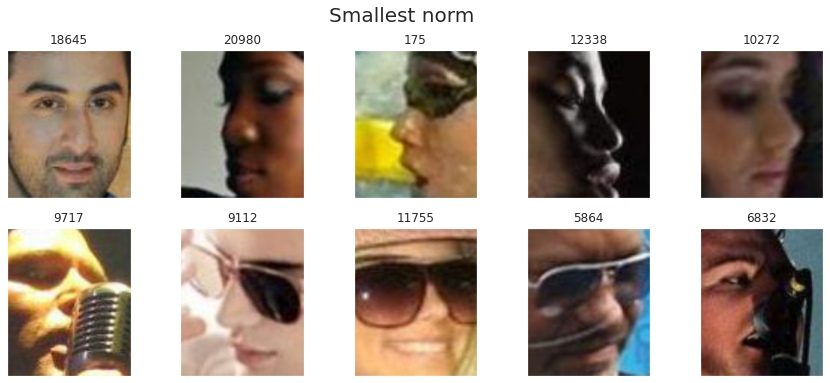

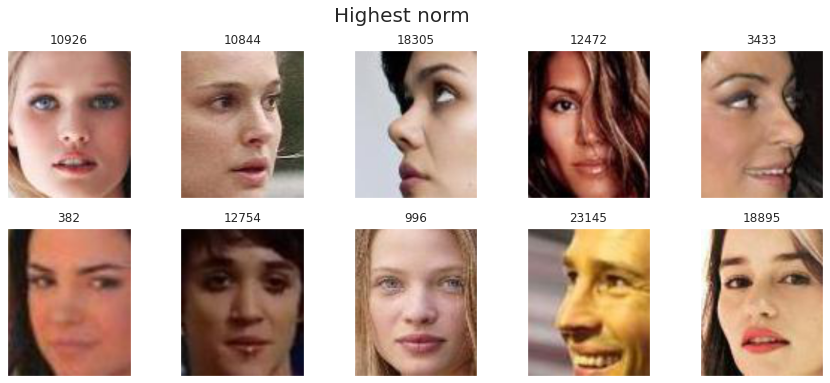

In [ ]:
# Trash in distractors

get_trash_photo(ind_distractors, distractors_trash_data)